<a href="https://colab.research.google.com/github/FarahFarjana/Heart_Failure_Prediction/blob/main/Heart_Failure_Prediction_Using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load and Explore Data
data = pd.read_csv("12-heart_failure_clinical_records_dataset.csv")
print(f"Dataset Shape: {data.shape}")
print(f"Missing Values: {data.isnull().sum().sum()}")

class_counts = data['DEATH_EVENT'].value_counts()
minority_percentage = min(class_counts) / len(data) * 100
print(f"Class Distribution:")
print(f"Survived (0): {class_counts[0]} ({class_counts[0]/len(data)*100:.1f}%)")
print(f"Died (1): {class_counts[1]} ({class_counts[1]/len(data)*100:.1f}%)")
print(f"Minority class percentage: {minority_percentage:.1f}%")

Dataset Shape: (299, 13)
Missing Values: 0
Class Distribution:
Survived (0): 203 (67.9%)
Died (1): 96 (32.1%)
Minority class percentage: 32.1%


In [ ]:
# OUTLIER HANDLING FUNCTIONS (TRAINING & APPLICATION)
def cap_outliers_conservative(df, features, factor=1.5):
    df_capped = df.copy()
    outlier_info = {}
    for feature in features:
        Q1 = df_capped[feature].quantile(0.25)
        Q3 = df_capped[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        # Count outliers before capping
        outliers_count = df_capped[(df_capped[feature] < lower_bound) |
                                  (df_capped[feature] > upper_bound)].shape[0]
        # Cap outliers
        df_capped[feature] = np.where(
            df_capped[feature] < lower_bound, lower_bound,
            np.where(df_capped[feature] > upper_bound, upper_bound, df_capped[feature]))
        outlier_info[feature] = {
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'outliers_capped': outliers_count}
    return df_capped, outlier_info

def apply_outlier_capping(df, outlier_info):
    """Applying previously computed outlier capping parameters to new data."""
    df_capped = df.copy()
    for feature, info in outlier_info.items():
        if feature in df_capped.columns:
            df_capped[feature] = np.where(
                df_capped[feature] < info['lower_bound'], info['lower_bound'],
                np.where(df_capped[feature] > info['upper_bound'], info['upper_bound'],
                        df_capped[feature]))
    return df_capped

In [ ]:
# TRANSFORMATION FUNCTIONS (TRAINING & APPLICATION)
def transformation_fit(data, features, skewness_threshold=1.0, min_improvement=0.1, max_skew_after=1.0):
    """Fit transformations and return transformation parameters."""
    transform_info = {}
    for feature in features:
        original_skewness = data[feature].skew()
        action = 'skipped'
        method = None
        improvement = 0
        if original_skewness > skewness_threshold:
            # log1p first if all values are positive
            if (data[feature] >= 0).all():
                transformed = np.log1p(data[feature])
                new_skewness = pd.Series(transformed).skew()
                if (abs(new_skewness) < abs(original_skewness) - min_improvement) and \
                   (abs(new_skewness) <= max_skew_after):
                    action = 'transformed'
                    method = 'log1p'
                    improvement = abs(original_skewness) - abs(new_skewness)
                else:
                    # reciprocal (only if all values > 0)
                    if (data[feature] > 0).all():
                        transformed = 1 / data[feature]
                        new_skewness = pd.Series(transformed).skew()

                        if (abs(new_skewness) < abs(original_skewness) - min_improvement) and \
                           (abs(new_skewness) <= max_skew_after):
                            action = 'transformed'
                            method = 'reciprocal'
                            improvement = abs(original_skewness) - abs(new_skewness)
        elif 0.5 < original_skewness <= skewness_threshold:
            # sqrt if moderately skewed
            if (data[feature] >= 0).all():
                transformed = np.sqrt(data[feature])
                new_skewness = pd.Series(transformed).skew()

                if (abs(new_skewness) < abs(original_skewness) - min_improvement) and \
                   (abs(new_skewness) <= max_skew_after):
                    action = 'transformed'
                    method = 'sqrt'
                    improvement = abs(original_skewness) - abs(new_skewness)
        transform_info[feature] = {
            'action': action,
            'method': method,
            'original_skewness': original_skewness,
            'improvement': improvement}
    return transform_info

def apply_transformation(data, transform_info):
    """Applying previously fitted transformations to new data."""
    transformed_data = data.copy()
    transformation_methods = {
        'log1p': lambda x: np.log1p(x),
        'sqrt': lambda x: np.sqrt(x),
        'reciprocal': lambda x: 1 / x}  # Fixed: consistent with training
    for feature, info in transform_info.items():
        if info['action'] == 'transformed' and feature in transformed_data.columns:
            method = info['method']
            if method in transformation_methods:
                # Adding safety checks
                if method == 'reciprocal' and (transformed_data[feature] <= 0).any():
                    print(f"Warning: {feature} has non-positive values for reciprocal transform")
                    continue
                transformed_data[feature] = transformation_methods[method](transformed_data[feature])
    return transformed_data

In [ ]:
# FEATURE CATEGORIZATION & PREPROCESSING
continuous_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction',
                      'platelets', 'serum_creatinine', 'serum_sodium', 'time']
binary_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
features_to_cap = ['creatinine_phosphokinase', 'platelets', 'serum_creatinine']


In [ ]:
# PROPER TRAIN-TEST SPLIT (BEFORE PREPROCESSING)
print("TRAIN-TEST SPLIT (BEFORE PREPROCESSING)")
print("="*60)
X = data.drop('DEATH_EVENT', axis=1)
y = data['DEATH_EVENT']
# Split FIRST to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


TRAIN-TEST SPLIT (BEFORE PREPROCESSING)
Training set: 224 samples
Test set: 75 samples


In [ ]:
# PREPROCESSING ON TRAINING DATA ONLY
print("PREPROCESSING ON TRAINING DATA")
print("="*60)
# 1. Outlier handling on training data
X_train_capped, outlier_info = cap_outliers_conservative(X_train, features_to_cap, factor=2.0)
# Apply same capping to test data
X_test_capped = apply_outlier_capping(X_test, outlier_info)
print("OUTLIER HANDLING SUMMARY:")
for feature, info in outlier_info.items():
    print(f"{feature}: {info['outliers_capped']} outliers capped")
# 2. Transformation on training data
transform_info = transformation_fit(X_train_capped, continuous_features)
X_train_transformed = apply_transformation(X_train_capped, transform_info)
# Apply same transformations to test data
X_test_transformed = apply_transformation(X_test_capped, transform_info)
print("\nTRANSFORMATION SUMMARY:")
transformed_features = [f for f, info in transform_info.items() if info['action'] == 'transformed']
print(f"Transformed features: {transformed_features}")

PREPROCESSING ON TRAINING DATA
OUTLIER HANDLING SUMMARY:
creatinine_phosphokinase: 20 outliers capped
platelets: 7 outliers capped
serum_creatinine: 17 outliers capped

TRANSFORMATION SUMMARY:
Transformed features: ['creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine']


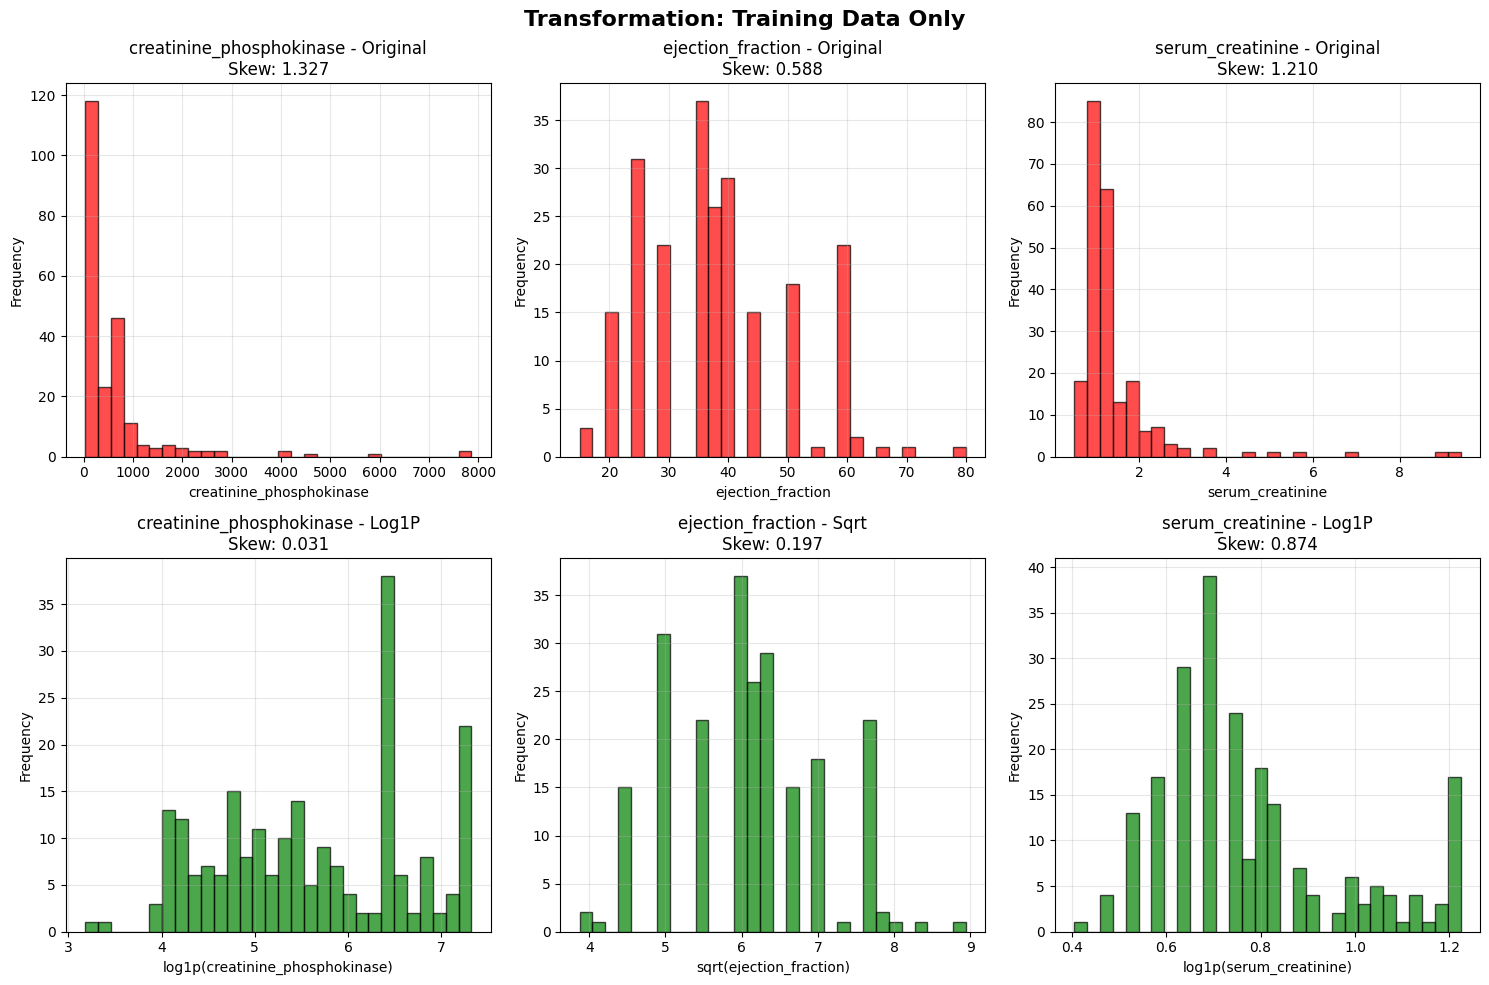

In [ ]:
# VISUALIZATION: PREPROCESSING EFFECTS
# Original vs Processed Data Visualization
if transformed_features:
    n_features = len(transformed_features)
    fig, axes = plt.subplots(2, n_features, figsize=(5*n_features, 10))
    if n_features == 1:
        axes = axes.reshape(-1, 1)
    fig.suptitle('Transformation: Training Data Only', fontsize=16, fontweight='bold')
    for i, feature in enumerate(transformed_features):
        # Original
        axes[0, i].hist(X_train[feature], bins=30, alpha=0.7, color='red', edgecolor='black')
        axes[0, i].set_title(f'{feature} - Original\nSkew: {transform_info[feature]["original_skewness"]:.3f}')
        axes[0, i].set_xlabel(feature)
        axes[0, i].set_ylabel('Frequency')
        axes[0, i].grid(alpha=0.3)
        # Transformed
        method = transform_info[feature]['method']
        axes[1, i].hist(X_train_transformed[feature], bins=30, alpha=0.7, color='green', edgecolor='black')
        axes[1, i].set_title(f'{feature} - {method.title()}\nSkew: {X_train_transformed[feature].skew():.3f}')
        axes[1, i].set_xlabel(f'{method}({feature})')
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

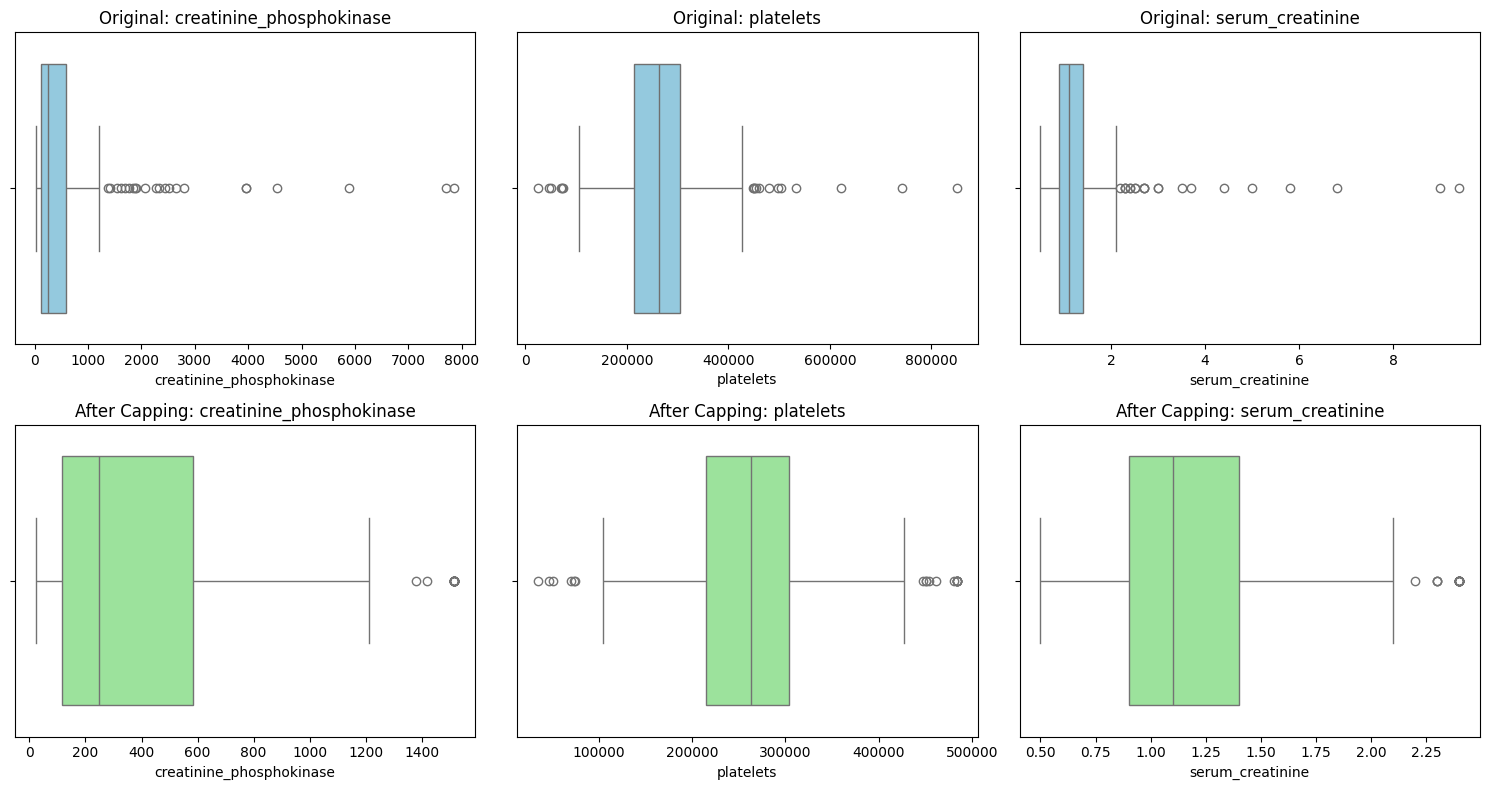

In [ ]:
# Outlier capping visualization
plt.figure(figsize=(15, 8))
for i, feature in enumerate(features_to_cap, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=X_train[feature], color='skyblue')
    plt.title(f'Original: {feature}')
    plt.subplot(2, 3, i+3)
    sns.boxplot(x=X_train_capped[feature], color='lightgreen')
    plt.title(f'After Capping: {feature}')
plt.tight_layout()
plt.show()

CORRELATION ANALYSIS


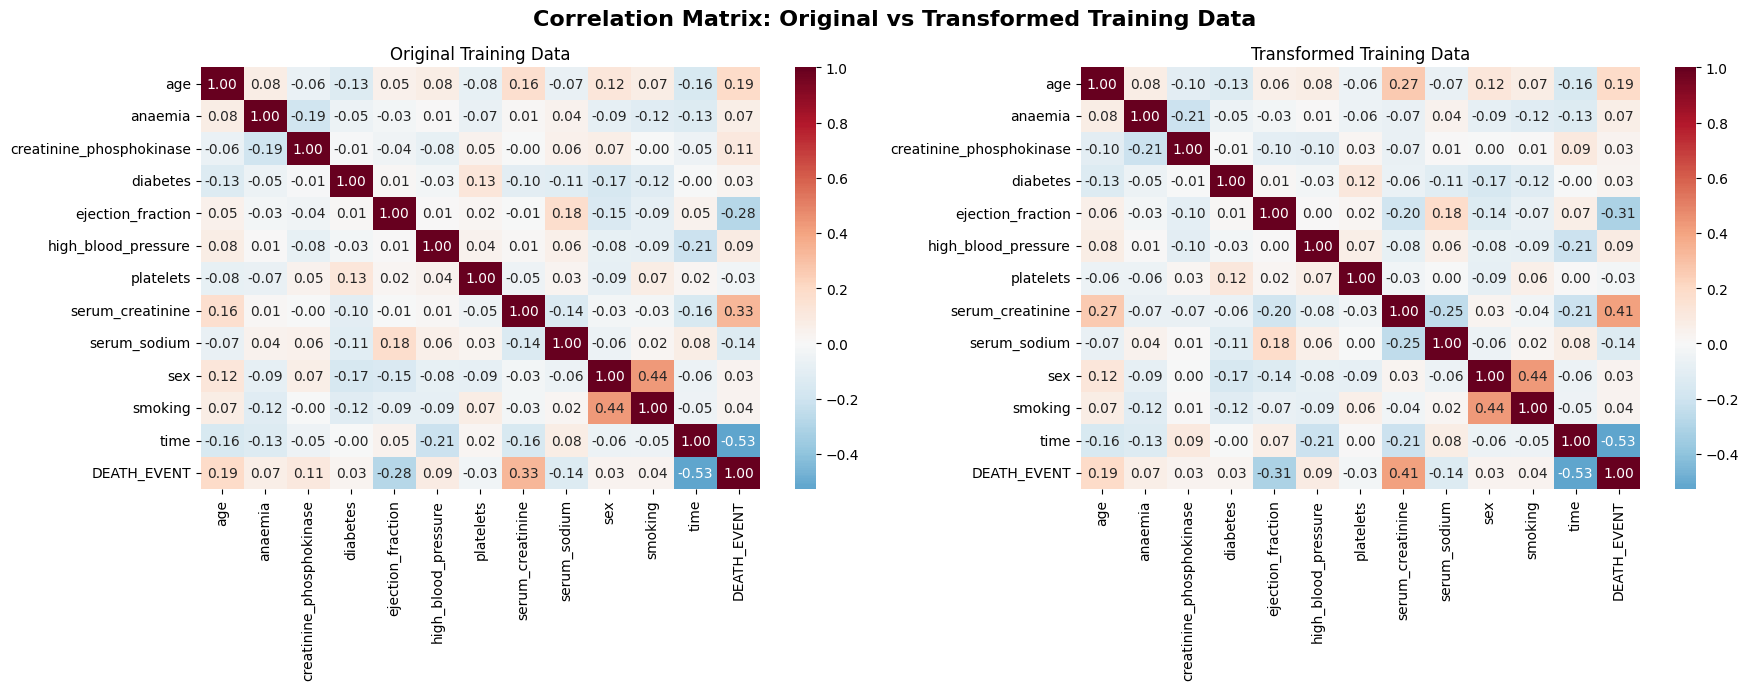

In [ ]:
# CORRELATION ANALYSIS
print("CORRELATION ANALYSIS")
print("="*60)
# Create combined datasets for correlation analysis
train_original = X_train.copy()
train_original['DEATH_EVENT'] = y_train
train_processed = X_train_transformed.copy()
train_processed['DEATH_EVENT'] = y_train
# Correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Correlation Matrix: Original vs Transformed Training Data', fontsize=16, fontweight='bold')
# Original correlation
corr_original = train_original.corr()
sns.heatmap(corr_original, annot=True, fmt=".2f", cmap='RdBu_r', center=0, ax=axes[0])
axes[0].set_title('Original Training Data')
# Transformed correlation
corr_transformed = train_processed.corr()
sns.heatmap(corr_transformed, annot=True, fmt=".2f", cmap='RdBu_r', center=0, ax=axes[1])
axes[1].set_title('Transformed Training Data')
plt.tight_layout()
plt.show()

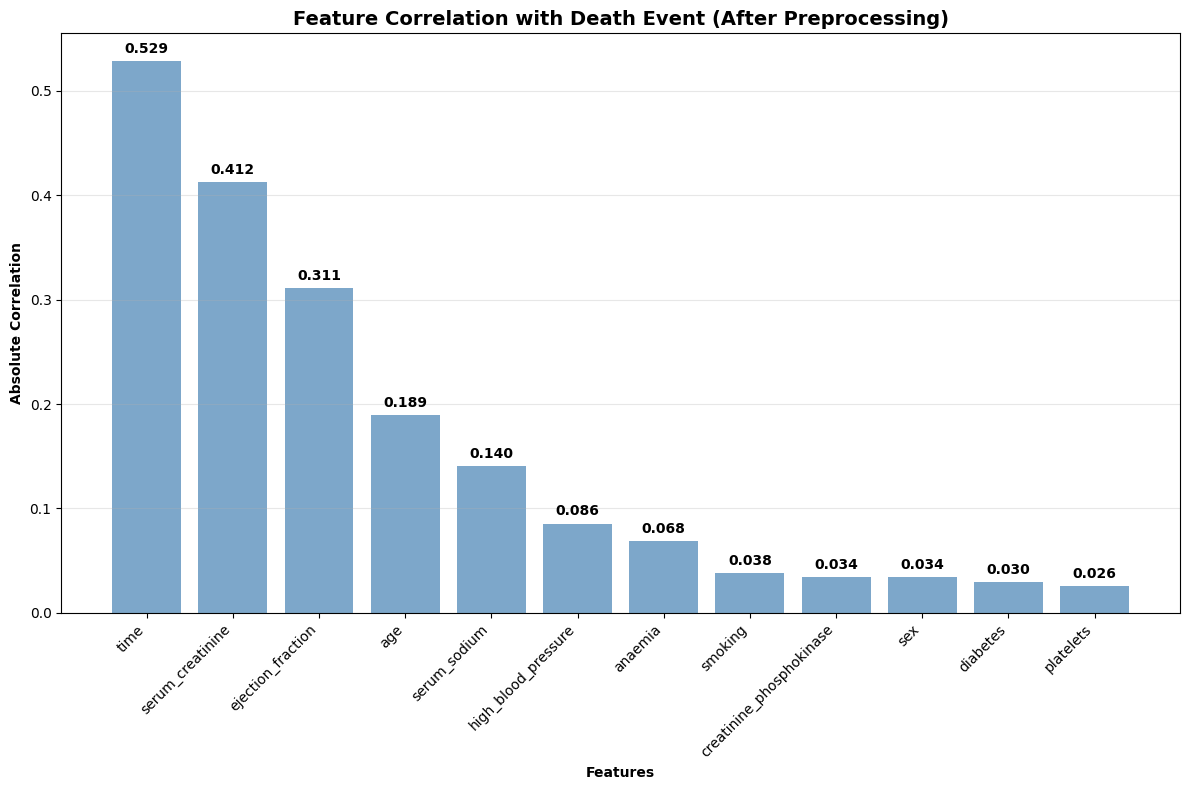

In [ ]:
# Target correlation comparison
target = 'DEATH_EVENT'
orig_target = corr_original[target].drop(target).abs().sort_values(ascending=False)
trans_target = corr_transformed[target].drop(target).abs().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
features_corr = trans_target
bars = plt.bar(range(len(features_corr)), features_corr.values, color='steelblue', alpha=0.7)

for i, (feature, value) in enumerate(features_corr.items()):
    plt.text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
plt.title('Feature Correlation with Death Event (After Preprocessing)', fontsize=14, fontweight='bold')
plt.xlabel('Features', fontweight='bold')
plt.ylabel('Absolute Correlation', fontweight='bold')
plt.xticks(range(len(features_corr)), features_corr.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# SMOTE APPLICATION
minority_class_ratio = min(y_train.value_counts()) / len(y_train)
apply_smote = minority_class_ratio < 0.40
print(f"Class Balance Analysis:")
print(f"Training set minority class ratio: {minority_class_ratio:.3f}")
print(f"Apply SMOTE: {'Yes' if apply_smote else 'No'}")
if apply_smote:
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)
    print(f"After SMOTE: {len(X_train_transformed)} → {len(X_train_balanced)} samples")
else:
    X_train_balanced, y_train_balanced = X_train_transformed.copy(), y_train.copy()


Class Balance Analysis:
Training set minority class ratio: 0.321
Apply SMOTE: Yes
After SMOTE: 224 → 304 samples


In [ ]:
# MODEL TRAINING WITH PIPELINES (NOW INCLUDING SVM)
def create_model_pipelines():
    pipelines = {}
    # Logistic Regression with scaling
    pipelines['Logistic Regression'] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000, random_state=42))
    ])
    # Decision Tree (no scaling needed)
    pipelines['Decision Tree'] = Pipeline([
        ('model', DecisionTreeClassifier(random_state=42))
    ])
    # Random Forest (no scaling needed)
    pipelines['Random Forest'] = Pipeline([
        ('model', RandomForestClassifier(random_state=42))
    ])
    # SVM with scaling (essential for SVM)
    pipelines['SVM'] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(probability=True, random_state=42))  # probability=True for ROC curve
    ])
    return pipelines

In [ ]:
# Define parameter grids for GridSearchCV (including SVM)
def get_param_grids():
    param_grids = {
        'Logistic Regression': {
            'model__C': [0.1, 1, 10],
            'model__penalty': ['l2']
        },
        'Decision Tree': {
            'model__criterion': ['entropy', 'gini'],
            'model__max_depth': [3, 5, 7, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 3, 5]
        },
        'Random Forest': {
            'model__n_estimators': [50, 100],
            'model__criterion': ['entropy', 'gini'],
            'model__max_depth': [5, 7, None],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 3],
            'model__max_features': ['sqrt']
        },
        'SVM': {
            'model__C': [0.1, 1, 10, 100],
            'model__kernel': ['rbf', 'linear', 'poly'],
            'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
        }
    }
    return param_grids


In [ ]:
# Train models with cross-validation
print("MODEL TRAINING WITH CROSS-VALIDATION (4 ALGORITHMS)")
print("="*60)
pipelines = create_model_pipelines()
param_grids = get_param_grids()
results = []
trained_models = {}

for model_name, pipeline in pipelines.items():
    print(f"\nTraining {model_name}...")
    # Grid search with proper cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grids[model_name],
        cv=5,
        scoring='f1',
        n_jobs=-1)

    grid_search.fit(X_train_balanced, y_train_balanced)
    best_model = grid_search.best_estimator_

    # Predictions
    y_pred = best_model.predict(X_test_transformed)
    y_proba = best_model.predict_proba(X_test_transformed)[:, 1]

    # Cross-validation scores
    cv_scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=5, scoring='f1')

    # Store results
    results.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1_Score': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_proba),
        'CV_F1_Mean': cv_scores.mean(),
        'CV_F1_Std': cv_scores.std()
    })

    trained_models[model_name] = {
        'model': best_model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'best_params': grid_search.best_params_
    }

results_df = pd.DataFrame(results)

MODEL TRAINING WITH CROSS-VALIDATION (4 ALGORITHMS)

Training Logistic Regression...

Training Decision Tree...

Training Random Forest...

Training SVM...


In [ ]:
# Display results
print("MODEL PERFORMANCE COMPARISON (4 ALGORITHMS)")
print("="*80)
display_cols = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC']
print(results_df[display_cols].round(3).to_string(index=False))


MODEL PERFORMANCE COMPARISON (4 ALGORITHMS)
              Model  Accuracy  Precision  Recall  F1_Score  ROC_AUC
Logistic Regression     0.813      0.692   0.750     0.720    0.908
      Decision Tree     0.747      0.593   0.667     0.627    0.773
      Random Forest     0.840      0.800   0.667     0.727    0.911
                SVM     0.800      0.714   0.625     0.667    0.855


In [ ]:
# Print best parameters for each model
print("\nBEST PARAMETERS FOR EACH MODEL:")
print("="*60)
for model_name, model_info in trained_models.items():
    print(f"\n{model_name}:")
    for param, value in model_info['best_params'].items():
        print(f"  {param}: {value}")



BEST PARAMETERS FOR EACH MODEL:

Logistic Regression:
  model__C: 10
  model__penalty: l2

Decision Tree:
  model__criterion: entropy
  model__max_depth: None
  model__min_samples_leaf: 1
  model__min_samples_split: 5

Random Forest:
  model__criterion: gini
  model__max_depth: None
  model__max_features: sqrt
  model__min_samples_leaf: 1
  model__min_samples_split: 2
  model__n_estimators: 100

SVM:
  model__C: 100
  model__gamma: scale
  model__kernel: rbf


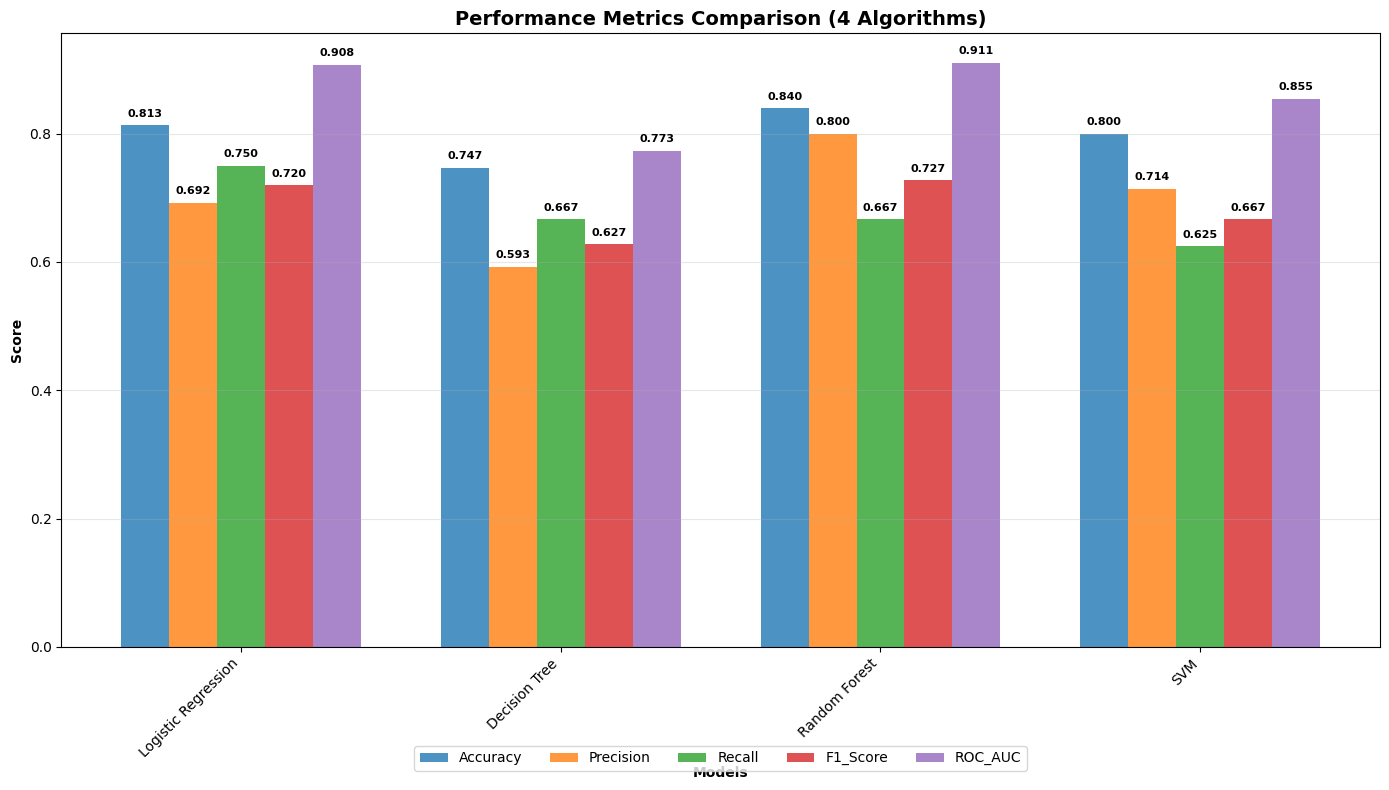

In [ ]:
# MODEL PERFORMANCE VISUALIZATIONS (UPDATED FOR 4 MODELS)
# Performance metrics comparison
plt.figure(figsize=(14, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
x = np.arange(len(results_df))
width = 0.15

for i, metric in enumerate(metrics):
    bars = plt.bar(x + i * width, results_df[metric], width,
                  label=metric, alpha=0.8, color=colors[i])
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.title('Performance Metrics Comparison (4 Algorithms)', fontsize=14, fontweight='bold')
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.xticks(x + width * 2, results_df['Model'], rotation=45, ha='right')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

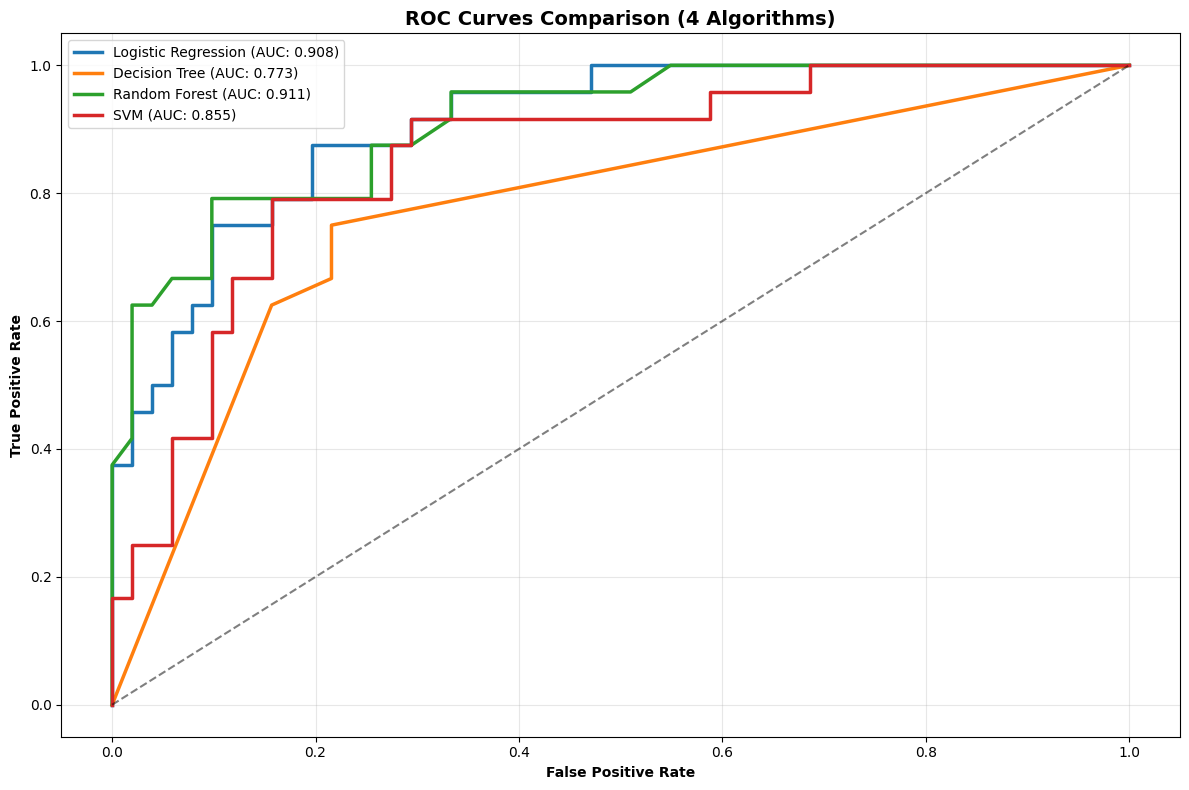

In [ ]:
# ROC curves comparison (4 models)
plt.figure(figsize=(12, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (model_name, model_info) in enumerate(trained_models.items()):
    fpr, tpr, _ = roc_curve(y_test, model_info['y_proba'])
    auc_score = roc_auc_score(y_test, model_info['y_proba'])
    plt.plot(fpr, tpr, label=f'{model_name} (AUC: {auc_score:.3f})',
             linewidth=2.5, color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curves Comparison (4 Algorithms)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

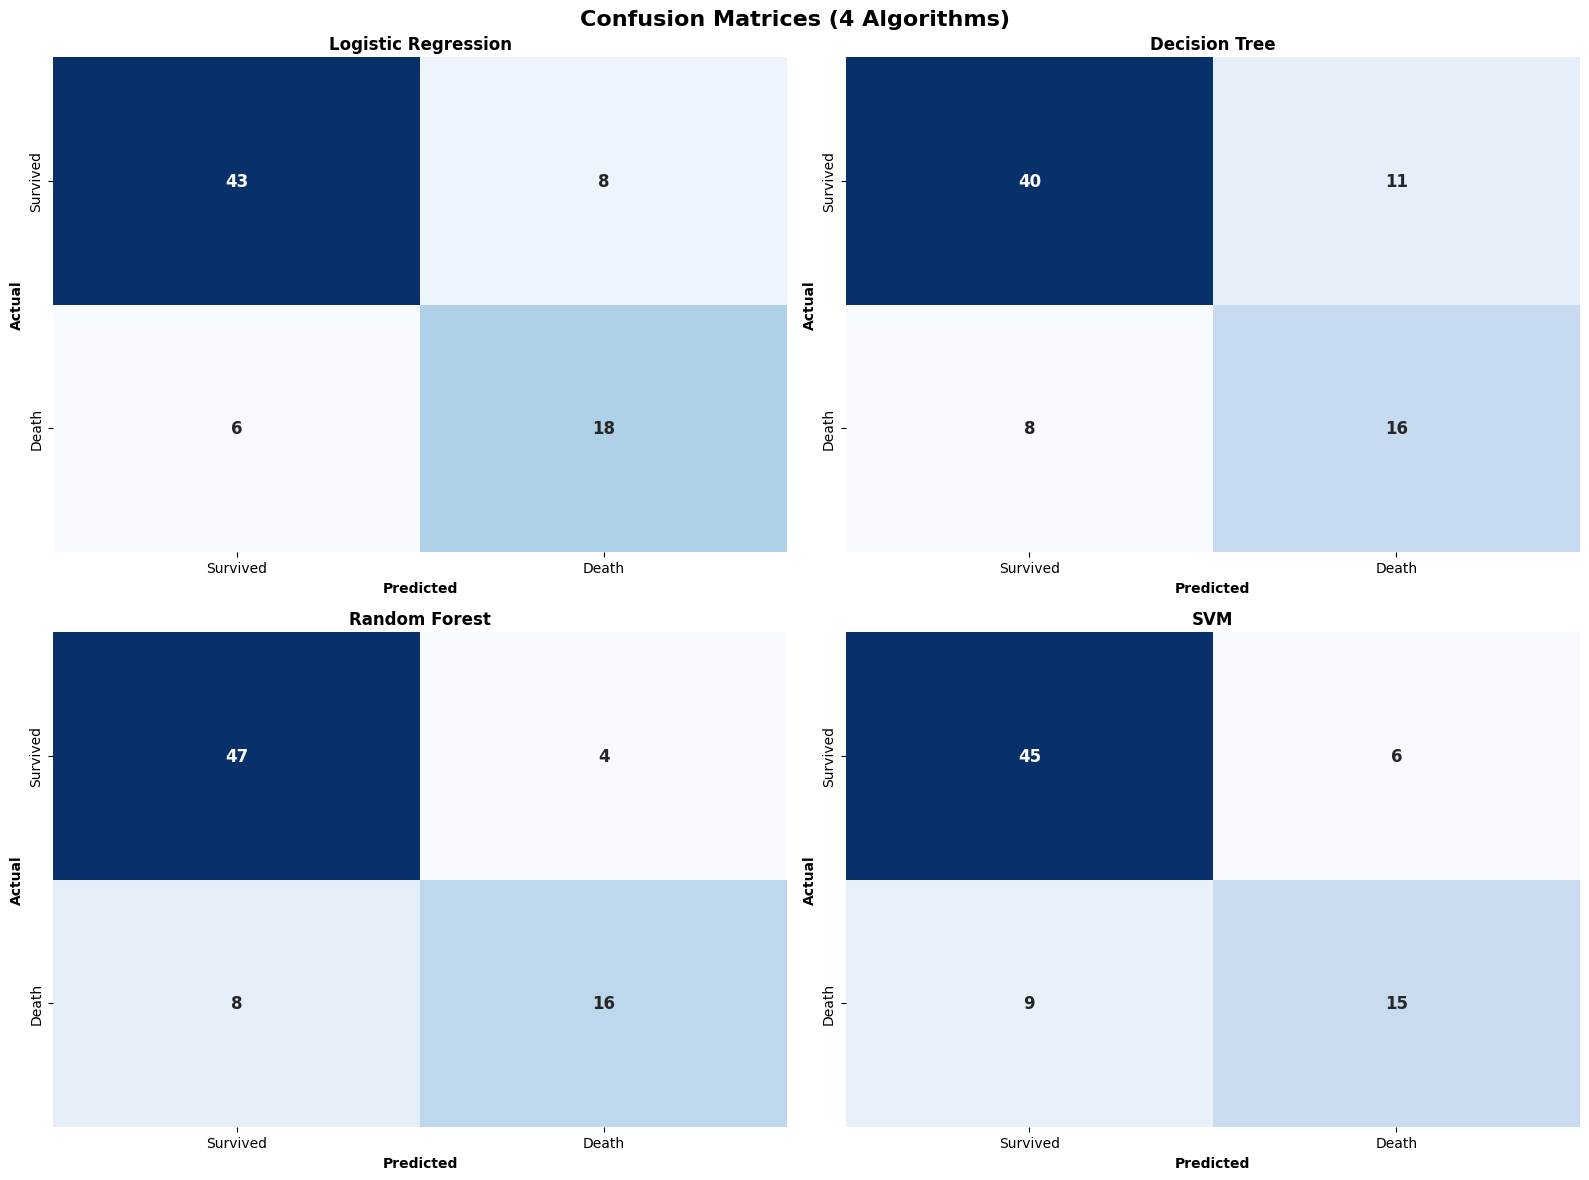

In [ ]:
# Confusion matrices (4 models)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Confusion Matrices (4 Algorithms)', fontsize=16, fontweight='bold')
axes = axes.flatten()

for i, (model_name, model_info) in enumerate(trained_models.items()):
    cm = confusion_matrix(y_test, model_info['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i],
               annot_kws={'fontsize': 12, 'fontweight': 'bold'})
    axes[i].set_title(f'{model_name}', fontweight='bold')
    axes[i].set_xlabel('Predicted', fontweight='bold')
    axes[i].set_ylabel('Actual', fontweight='bold')
    axes[i].set_xticklabels(['Survived', 'Death'])
    axes[i].set_yticklabels(['Survived', 'Death'])

plt.tight_layout()
plt.show()

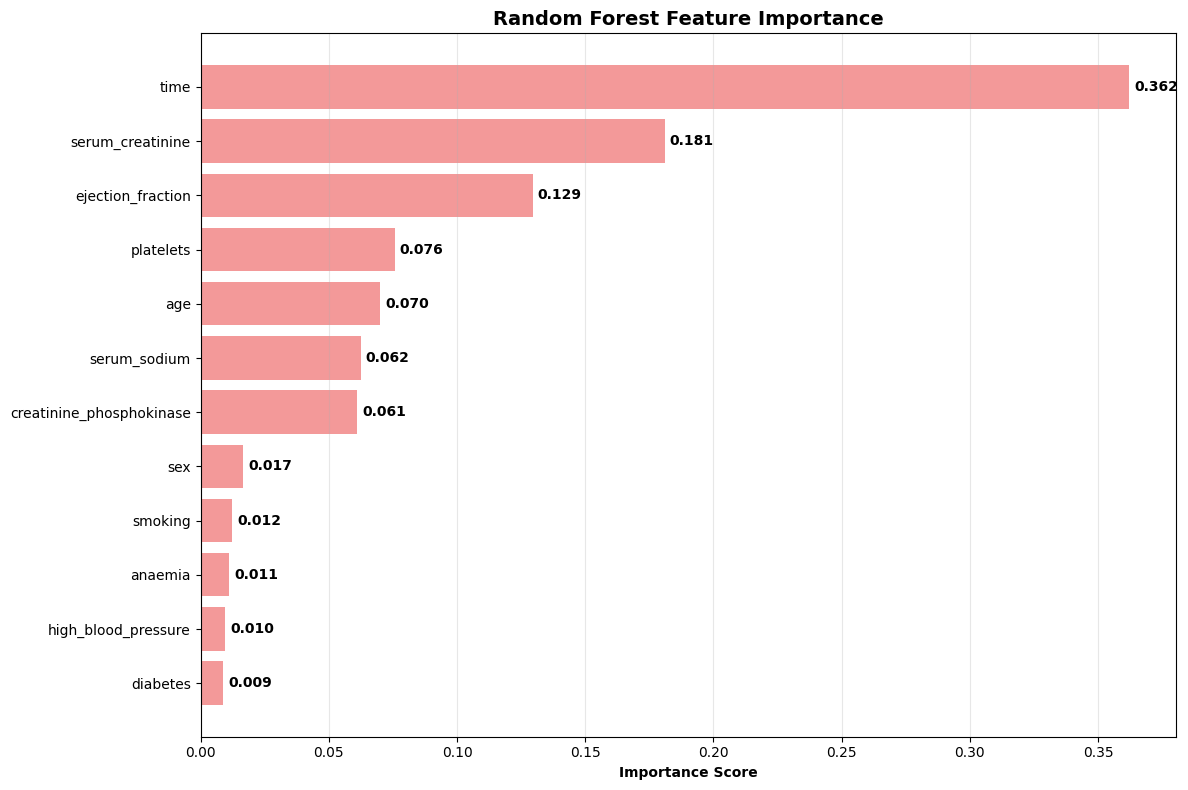

In [ ]:
# Feature importance (Random Forest)
if 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': X_train_balanced.columns,
        'importance': rf_model.named_steps['model'].feature_importances_
    }).sort_values('importance', ascending=True)

    plt.figure(figsize=(12, 8))
    bars = plt.barh(feature_importance['feature'], feature_importance['importance'],
                   color='lightcoral', alpha=0.8)
    for i, (bar, value) in enumerate(zip(bars, feature_importance['importance'])):
        plt.text(value + 0.002, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', va='center', fontweight='bold')
    plt.xlabel('Importance Score', fontweight='bold')
    plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# SVM Decision Boundary Visualization (if SVM uses linear kernel)
if 'SVM' in trained_models:
    svm_model = trained_models['SVM']['model']
    svm_kernel = svm_model.named_steps['model'].kernel
    print(f"\nSVM Analysis:")
    print(f"Best kernel: {svm_kernel}")
    print(f"Best C parameter: {svm_model.named_steps['model'].C}")
    print(f"Best gamma parameter: {svm_model.named_steps['model'].gamma}")
    print(f"Number of support vectors: {svm_model.named_steps['model'].n_support_}")



SVM Analysis:
Best kernel: rbf
Best C parameter: 100
Best gamma parameter: scale
Number of support vectors: [65 71]


In [ ]:
# UPDATED PREDICTION FUNCTION FOR 4 MODELS
def predict_heart_failure_risk(patient_data, trained_models, outlier_info, transform_info):
    """
    Predict heart failure risk using all 4 trained models
    """
    if len(patient_data) != 12:
        raise ValueError("Patient data must contain exactly 12 features.")

    feature_names = X.columns.tolist()
    patient_df = pd.DataFrame([patient_data], columns=feature_names)

    # Apply same preprocessing pipeline as training
    # 1. Outlier capping
    patient_capped = apply_outlier_capping(patient_df, outlier_info)
    # 2. Transformation
    patient_transformed = apply_transformation(patient_capped, transform_info)

    print("HEART FAILURE RISK PREDICTION (4 ALGORITHMS)")
    print("="*60)
    predictions = []
    for model_name, model_info in trained_models.items():
        # Use the trained pipeline (includes scaling if needed)
        prediction = model_info['model'].predict(patient_transformed)[0]
        probability = model_info['model'].predict_proba(patient_transformed)[0]

        risk_label = 'HIGH RISK' if prediction == 1 else 'LOW RISK'
        confidence = max(probability) * 100
        death_probability = probability[1] * 100

        print(f"\n{model_name}:")
        print(f"  → Risk Level: {risk_label}")
        print(f"  → Death Probability: {death_probability:.1f}%")
        print(f"  → Confidence: {confidence:.1f}%")

        predictions.append({
            'Model': model_name,
            'Prediction': prediction,
            'Death_Probability': death_probability,
            'Confidence': confidence
        })
        # Ensemble prediction (majority voting)
    ensemble_pred = 1 if sum(p['Prediction'] for p in predictions) >= len(predictions)/2 else 0
    avg_death_prob = np.mean([p['Death_Probability'] for p in predictions])

    print(f"\n{'='*20} ENSEMBLE RESULT {'='*20}")
    print(f"Final Prediction: {'HIGH RISK' if ensemble_pred == 1 else 'LOW RISK'}")
    print(f"Average Death Probability: {avg_death_prob:.1f}%")
    print(f"Consensus: {sum(p['Prediction'] for p in predictions)}/4 models predict high risk")
    print("="*60)

    return predictions


In [ ]:
# SAMPLE PREDICTION WITH ALL 4 MODELS
print("\nSAMPLE PATIENT PREDICTION (4 ALGORITHMS)")
print("="*60)
# Sample patient data
sample_patient = [65, 0, 582, 1, 38, 1, 265000, 1.1, 137, 1, 0, 115]
feature_labels = ['Age', 'Anaemia', 'Creatinine Phosphokinase', 'Diabetes',
                 'Ejection Fraction', 'High Blood Pressure', 'Platelets',
                 'Serum Creatinine', 'Serum Sodium', 'Sex', 'Smoking', 'Time']

print("Patient Profile:")
for label, value in zip(feature_labels, sample_patient):
    print(f"  {label}: {value}")


SAMPLE PATIENT PREDICTION (4 ALGORITHMS)
Patient Profile:
  Age: 65
  Anaemia: 0
  Creatinine Phosphokinase: 582
  Diabetes: 1
  Ejection Fraction: 38
  High Blood Pressure: 1
  Platelets: 265000
  Serum Creatinine: 1.1
  Serum Sodium: 137
  Sex: 1
  Smoking: 0
  Time: 115


In [ ]:
# Make prediction with all 4 models
sample_predictions = predict_heart_failure_risk(
    sample_patient, trained_models, outlier_info, transform_info)


HEART FAILURE RISK PREDICTION (4 ALGORITHMS)

Logistic Regression:
  → Risk Level: LOW RISK
  → Death Probability: 22.1%
  → Confidence: 77.9%

Decision Tree:
  → Risk Level: LOW RISK
  → Death Probability: 0.0%
  → Confidence: 100.0%

Random Forest:
  → Risk Level: LOW RISK
  → Death Probability: 4.0%
  → Confidence: 96.0%

SVM:
  → Risk Level: LOW RISK
  → Death Probability: 4.3%
  → Confidence: 95.7%

==================== ENSEMBLE RESULT ====================
Final Prediction: LOW RISK
Average Death Probability: 7.6%
Consensus: 0/4 models predict high risk


In [ ]:
# Model comparison summary
print("\nMODEL COMPARISON SUMMARY:")
print("="*60)
best_model = results_df.loc[results_df['F1_Score'].idxmax(), 'Model']
print(f"Best performing model (F1-Score): {best_model}")
print(f"Best F1-Score: {results_df['F1_Score'].max():.3f}")
print(f"Best ROC-AUC: {results_df['ROC_AUC'].max():.3f}")



MODEL COMPARISON SUMMARY:
Best performing model (F1-Score): Random Forest
Best F1-Score: 0.727
Best ROC-AUC: 0.911


In [ ]:
# Final recommendations
print("\nFINAL RECOMMENDATIONS:")
print("="*60)
print("1. SVM with RBF kernel often performs well on non-linear relationships")
print("2. Random Forest provides good interpretability with feature importance")
print("3. Logistic Regression offers fast inference and good baseline performance")
print("4. Decision Tree provides the most interpretable decision rules")
print("5. Ensemble approach (majority voting) can provide more robust predictions")


FINAL RECOMMENDATIONS:
1. SVM with RBF kernel often performs well on non-linear relationships
2. Random Forest provides good interpretability with feature importance
3. Logistic Regression offers fast inference and good baseline performance
4. Decision Tree provides the most interpretable decision rules
5. Ensemble approach (majority voting) can provide more robust predictions
